# Image clasification with CNN,using different approaches 
The purpose of this notebook is to compare the perfomance of Convolutional neural networks plus regularization and image augmenation
trained with smalls datasets vs the transfer learning aproach: using pre-trained models.

In [1]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

%matplotlib inline

C:\Users\EduardoCastillo\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# we load up the dataset containing 25000 dogs and cats images
files = glob.glob('dogsCatsTrainData/*')

In [3]:
# we separate the images
cat_files = [fn for fn in files if 'cat' in fn]
dog_files = list(set(files) - set(cat_files))
len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
# we build our smaller dataset, so that we have 3,000 images for training, 1,000 images for validation, and 1,000 images for our
# test dataset (with equal representation for the two animal categories).

cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)

cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)

cat_files = [fn for fn in cat_files if fn not in cat_val]
dog_files = [fn for fn in dog_files if fn not in dog_val]

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

In [5]:
# print datasetsb
print('Cat datasets:', len(cat_train), len(cat_val), len(cat_test))
print('Dog datasets:', len(dog_train), len(dog_val), len(dog_test))

Cat datasets: 1500 500 500
Dog datasets: 1500 500 500


In [6]:
# concatenating arrays of cats and dogs
train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

In [109]:
# writing datasets in our disk in case we dont want to have them in our main memory

train_dir = 'dog_cat_train_data'
val_dir = 'dog_cat_val_data'
test_dir = 'dog_cat_test_data'

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)

for fn in test_files:
    shutil.copy(fn, test_dir)

In [9]:
# set the img dimension size (150,150), transform images into arrays and get the imgs labels. Each image will be at the end
# an array of dimensions(150,150,3) the 3 is for red, green and blue (RGB) channels.
IMG_DIM = (150, 150)

train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM))
              for img in train_files]
train_imgs = np.array(train_imgs)

train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_imgs = [img_to_array(
    load_img(img, target_size=IMG_DIM)) for img in validate_files]
validation_imgs = np.array(validation_imgs)

validation_labels = [fn.split('\\')[1].split('.')[0].strip()
                     for fn in validate_files]

print('Train dataset shape:', train_imgs.shape,
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


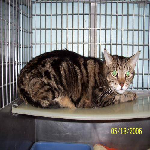

In [10]:
# we now scale each image pixel values from (0,255) to (0,1) range. Deep learning models usually perforn better with small
# input values.

train_imgs = train_imgs.astype('float32')/255
validation_imgs = validation_imgs.astype('float32')/255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [11]:
train_imgs[0]

array([[[0.22745098, 0.20784314, 0.23529412],
        [0.3372549 , 0.30980393, 0.37254903],
        [0.16862746, 0.17254902, 0.15294118],
        ...,
        [0.32156864, 0.3254902 , 0.34117648],
        [0.45490196, 0.50980395, 0.5137255 ],
        [0.5254902 , 0.6156863 , 0.64705884]],

       [[0.31764707, 0.29803923, 0.3254902 ],
        [0.3764706 , 0.36078432, 0.41960785],
        [0.21176471, 0.21568628, 0.19607843],
        ...,
        [0.2901961 , 0.28627452, 0.30980393],
        [0.2784314 , 0.30588236, 0.32941177],
        [0.3254902 , 0.34901962, 0.39607844]],

       [[0.30980393, 0.29803923, 0.33333334],
        [0.3647059 , 0.34901962, 0.41568628],
        [0.27058825, 0.2784314 , 0.26666668],
        ...,
        [0.40784314, 0.38431373, 0.43137255],
        [0.3764706 , 0.3764706 , 0.42352942],
        [0.3372549 , 0.30588236, 0.34901962]],

       ...,

       [[0.10196079, 0.11372549, 0.14117648],
        [0.10196079, 0.11372549, 0.14117648],
        [0.10980392, 0

In [12]:
# now we set up some configuration parameters and do some basic feauture pre processing
# The batch_size indicates the total number of images passed to the model per iteration.
batch_size = 30
num_classes = 2  # The weights of the units in layers are updated after each iteration
epochs = 30  # n epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches
input_shape = (150, 150, 3)

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


In [21]:
# we will first build a basic CNN model sith 3 convolutional layers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu', input_shape=input_shape))
# note: consider using overlapping pooling, e.g poolsize=2x2 and strides= 1
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36992)             0         
__________

In [29]:
# lets train the model we compiled above , vanilla CNN model.

history = model.fit(x=train_imgs, y=train_labels_enc,
                    validation_data=(validation_imgs, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 187s 62ms/step - loss: 3.8310 - acc: 0.5187 - val_loss: 0.6656 - val_acc: 0.6590
Epoch 2/30
3000/3000 [==============================] - 189s 63ms/step - loss: 0.6561 - acc: 0.6293 - val_loss: 0.5769 - val_acc: 0.6860
Epoch 3/30
3000/3000 [==============================] - 182s 61ms/step - loss: 0.5640 - acc: 0.7163 - val_loss: 0.5513 - val_acc: 0.7200
Epoch 4/30
3000/3000 [==============================] - 169s 56ms/step - loss: 0.4950 - acc: 0.7587 - val_loss: 0.5359 - val_acc: 0.7350
Epoch 5/30
3000/3000 [==============================] - 171s 57ms/step - loss: 0.4095 - acc: 0.8087 - val_loss: 0.5758 - val_acc: 0.7270
Epoch 6/30
3000/3000 [==============================] - 163s 54ms/step - loss: 0.3221 - acc: 0.8597 - val_loss: 0.6371 - val_acc: 0.7340
Epoch 7/30
3000/3000 [==============================] - 162s 54ms/step - loss: 0.2410 - acc: 0.9007 - val_loss: 0.6419 - val_acc: 

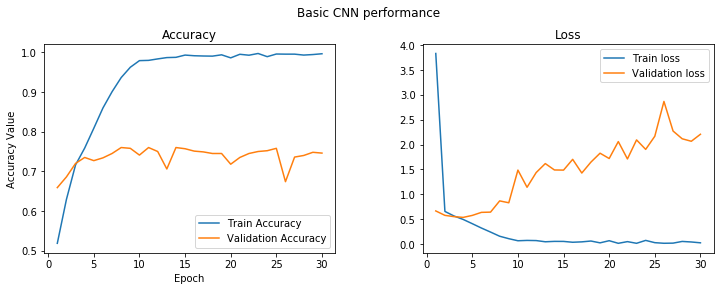

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can se that after 3-5 epochs the model starts **overfitting** on the training data, lets try to improve the model by using 
**regularization**. We will also add **one more convolutinal layer**( 4 in  total) and **another dense hidden layer**.
Also we will **add dropout** after each hidden dense layer, dropout will randomly set a fraction of units from a layer to zero,
in this case we will dropout 30% of the units in our dense layers.

In [12]:
model_r = Sequential()

model_r.add(Conv2D(16, kernel_size=(3, 3),
                   activation='relu', input_shape=input_shape))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_r.add(MaxPooling2D(pool_size=(2, 2)))

model_r.add(Flatten())
model_r.add(Dense(512, activation='relu'))
model_r.add(Dropout(0.3))

model_r.add(Dense(512, activation='relu'))
model_r.add(Dropout(0.3))

model_r.add(Dense(1, activation='sigmoid'))

model_r.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(), metrics=['accuracy'])

model_r.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 163s 54ms/step - loss: 0.7048 - acc: 0.5480 - val_loss: 0.6507 - val_acc: 0.6180
Epoch 2/30
3000/3000 [==============================] - 176s 59ms/step - loss: 0.6761 - acc: 0.5767 - val_loss: 0.6334 - val_acc: 0.6610
Epoch 3/30
3000/3000 [==============================] - 198s 66ms/step - loss: 0.6461 - acc: 0.6497 - val_loss: 0.6033 - val_acc: 0.6580
Epoch 4/30
3000/3000 [==============================] - 167s 56ms/step - loss: 0.5962 - acc: 0.6880 - val_loss: 0.6135 - val_acc: 0.6890
Epoch 5/30
3000/3000 [==============================] - 157s 52ms/step - loss: 0.5411 - acc: 0.7217 - val_loss: 0.5710 - val_acc: 0.7170
Epoch 6/30
3000/3000 [==============================] - 150s 50ms/step - loss: 0.4969 - acc: 0.7643 - val_loss: 0.5193 - val_acc: 0.7420
Epoch 7/30
3000/3000 [==============================] - 146s 49ms/step - loss: 0.4686 - acc: 0.7900 - val_loss: 0.5445 - val_acc: 

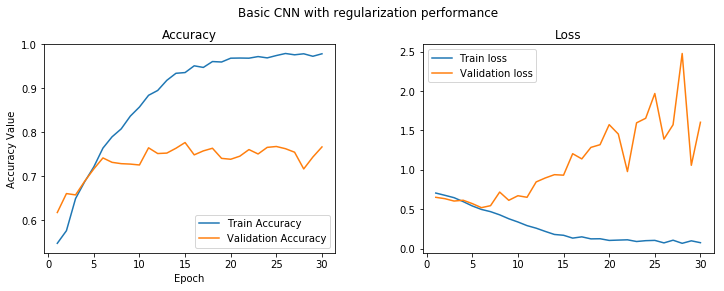

In [13]:
# lets train the model we compiled above , vanilla CNN with regularization model.

history_r = model_r.fit(x=train_imgs, y=train_labels_enc,
                        validation_data=(
                            validation_imgs, validation_labels_enc),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN with regularization performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history_r.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history_r.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_r.history['loss'], label='Train loss')
ax2.plot(epoch_list, history_r.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We can see that even with regularization the model **keeps overfitting** after some epochs, this is **caused by** the fact that we have an **small amount of training data** and the model keeps seeing the same images over the epochs. 

In [18]:
# we save the model in case we want to use it latter
model_r.save('cats_dogs_basic_cnn.h5')

# Image augmentation.
## we will add more training data by using a technique called "IMAGE AUGMENTATION".
The idea behind image augmentation is that we follow a set process of taking in existing images from our training dataset
and applying some image transformation operations to them, such as rotation, shearing, translation, zooming, and so on, 
to produce new, altered versions of existing images. Due to these random transformations, we don’t get the same images each time.
keras frame work has a excellent tool called "ImagedataGenerator"

In [11]:
# lets initialize two of the data generatos for our trainig and validation sets.

train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator()

 + Zooming the image randomly by a factor of **0.3** using the **zoom_range** parameter.  
 + Rotating the image randomly by **50** degrees using the **rotation_range** parameter.  
 * Translating the image randomly horizontally or vertically by a **0.2** factor of the image’s width or height using the **width_shift_range** and the **height_shift_range** parameters.  
 * Applying shear-based transformations randomly using the **shear_range** parameter.
 + Randomly flipping half of the images horizontally using the **horizontal_flip** parameter.  
 + Leveraging the **fill_mode** parameter to fill in new pixels for images after we apply any of the preceding operations (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

Labels ['cat', 'cat', 'cat', 'cat', 'cat']
Labels ['dog', 'dog', 'dog', 'dog', 'dog']


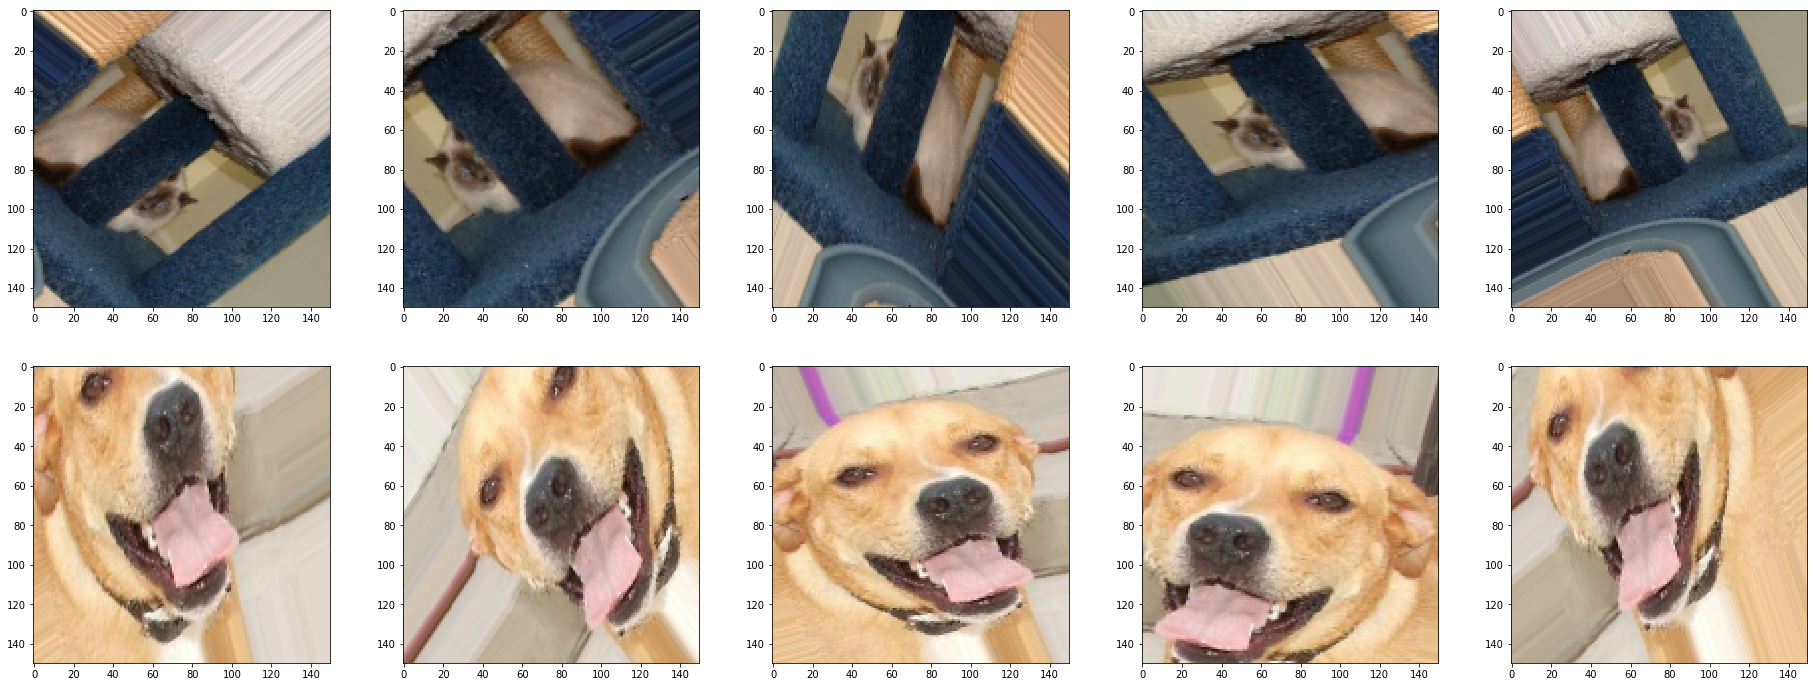

In [12]:
# lets see how these generated images would look.

cat_generator = train_datagen.flow(
    train_imgs[1000:1001], train_labels[1000:1001], batch_size=1)
cat = [next(cat_generator) for i in range(0, 5)]

fig, ax = plt.subplots(2, 5, figsize=(32, 12))
print('Labels', [item[1][0]for item in cat])
l = [ax[0][i].imshow(cat[i][0][0]) for i in range(0, 5)]

dog_generator = train_datagen.flow(
    train_imgs[2003:2004], train_labels[2003:2004], batch_size=1)
dog = [next(dog_generator) for i in range(0, 5)]
l2 = [ax[1][i].imshow(dog[i][0][0]) for i in range(0, 5)]
print('Labels', [item[1][0]for item in dog])

# CNN Model with regularization and Image augmentation

 Lets now train another model with regularization using the **image augmentation** data generator we created above. we will use the **same model architecture** than the previus one.

In [91]:
train_generator = train_datagen.flow(
    train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(
    validation_imgs, validation_labels_enc, batch_size=20)

model_aug = Sequential()

model_aug.add(Conv2D(16, kernel_size=(3, 3),
                     activation='relu', input_shape=input_shape))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))

model_aug.add(Flatten())
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))

model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))

model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

model_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

Epoch 1/100
100/100 [==============================] - 179s 2s/step - loss: 0.6935 - acc: 0.5117 - val_loss: 0.7018 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 159s 2s/step - loss: 0.6927 - acc: 0.5233 - val_loss: 0.6870 - val_acc: 0.5130
Epoch 3/100
100/100 [==============================] - 179s 2s/step - loss: 0.6842 - acc: 0.5590 - val_loss: 0.6680 - val_acc: 0.5930
Epoch 4/100
100/100 [==============================] - 166s 2s/step - loss: 0.6742 - acc: 0.5763 - val_loss: 0.6660 - val_acc: 0.5780
Epoch 5/100
100/100 [==============================] - 158s 2s/step - loss: 0.6643 - acc: 0.5983 - val_loss: 0.6721 - val_acc: 0.5720
Epoch 6/100
100/100 [==============================] - 178s 2s/step - loss: 0.6539 - acc: 0.6067 - val_loss: 0.6334 - val_acc: 0.6210
Epoch 7/100
100/100 [==============================] - 168s 2s/step - loss: 0.6461 - acc: 0.6237 - val_loss: 0.6454 - val_acc: 0.6270
Epoch 8/100
100/100 [==============================] - 150s 2s

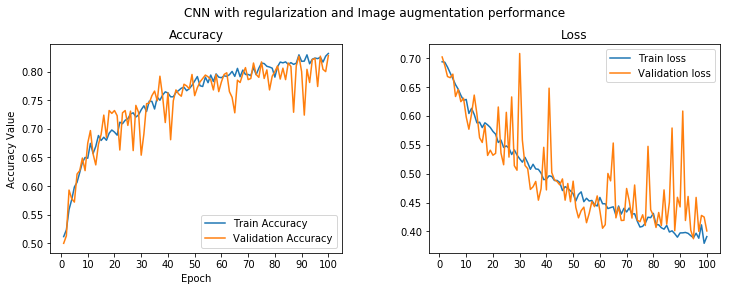

In [92]:
# lets now train the model

history_aug = model_aug.fit_generator(train_generator, validation_data=val_generator, steps_per_epoch=100, epochs=100,
                                      validation_steps=50, verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(
    'CNN with regularization and Image augmentation performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 101))
ax1.plot(epoch_list, history_aug.history['acc'], label='Train Accuracy')
ax1.plot(
    epoch_list, history_aug.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_aug.history['loss'], label='Train loss')
ax2.plot(epoch_list, history_aug.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We have **reduced** the default learning rate by a factor of **10** for our optimazers to **prevent** the model from **getting stuck in a local minima**, as we will sending many images with random transformations. Notice that this time instead of using **.fit** we used **.fit_generator**. The *train_generator* generates **30 images each time** , we set the *steps_per_epoch* parameter to **100** to train the model on **3000 randomly generated images** per epoch. Our *val_generator* generates 20 images each time so we will set the *validation_steps* to **50** to validate our model accurary on **1000 images** per epoch. Notice that we are **not applying** any **transformation** to the **validation data set**.

In [93]:
model_aug.save('cats_dogs_cnn_img_aug.h5')

# Transfer learning with Pre-trained CCN models

There are two popular ways of using transfer learning :
 * using a pre-trained model as a feature extractor.
 * Fine-tunning the pre-trained model.
 
The pre-trained model we will use is the popular **VGG-16 model**, developed by the *Visual Geometry Group* at the University of Oxford, which specializes in building very deep convuluational networks for large-scale visual recognition.

The VGG-16 model is **already trained** on a huge data set, the *ImageNet* set, with a lot of diverse image categories. We expect the model to already know a **robust hierarchy of feautures**, which are spatial, rotation and traslation invariant with regard to feautures learned by Basic CNN models. Hence, we also expect the model to act as a **good feature extractor** fow new images. These new images might be **brand new** to the model or might be part of totally **different categories**, but the model should still be able to extract relevant features from these images.




## The VGG-16 model architecture.

This model has **16 layers**, it was trained on the **ImageNet** database, in this link you can find the original paper of the model: https://arxiv.org/pdf/1409.1556.pdf.   
 
  

![image.png](attachment:image.png)

We can see that the model has **13 convolution layers** using **3 x 3 filters** along with **max pooling layers** for downsamplig, we can also see that the model has **Two fully connected hidden layers** with **4096** units in each of them,and a **final fully connected layer of 1000 units**, where each unit **represents one of the image categories** in the database.

We are **not going to** use the last **3 layers** since we will use our fully connected layers to predict **only 2 classes** instead of 1000, we will focus on the **first five building blocks**.

## Two models. 

* For **one of our models** we will **freeze** all five convolution blocks to make sure their **weights** do not get **updated** after each epoch. 

* For the **other model** we will **unfreeze** the **last two** convolution bloks applying **fine-tuning** the the 4th and 5th blocks so their weights **get updated** as we train our own model.

![image.png](attachment:image.png)

# 1. Pre-trained model as Feature extractor

In [13]:
# we load up the VGG-16 model from keras and freeze the convolution block.s

from keras.applications import vgg16
from keras.models import Model
import keras
import pandas as pd

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                  input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Layer name', 'Layer trainable'])

,Layer type,Layer name,Layer trainable
0,<keras.engine.input_layer.InputLayer object at 0x00000234EF2EA128>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x00000234FF556400>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x00000234FF5562E8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x00000234AB7DECC0>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x00000234AB7DEF28>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x00000234AB7F8DD8>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x00000234AB80A240>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x00000234AB8254E0>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x00000234AB8376D8>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x00000234AB84F978>,block3_conv3,False


The last activation feature map in the VGG-16 model (output from **block5_pool**) gives us the bottleneck features, which can be flattened and **fed to** a fully connected deep neural network classifier.   
The following snippet shows what the **bottleneck features** look like for a sample image from our training data.


(1, 4, 4, 512)


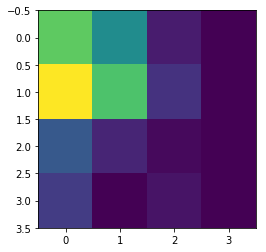

In [14]:
bottleneck_feature_example = vgg.predict(train_imgs[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:, :, 0])

We flatten the bottleneck features in the **vgg_model object** to make them ready to be fed to our fully connected clasifier. A way to save time in model training is to use this model and **extract out all of the features** from ur training and validation sets and **then fed them** as inputs to our classifier. 

In [15]:
# Lets extract out the bottleneck features from our training and validation sets.


def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features


train_features_vgg = get_bottleneck_features(vgg_model, train_imgs)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs)

print('Train Boottleneck Features:', train_features_vgg.shape,
      '\Validation Bottleneck Features:', validation_features_vgg.shape)

Train Boottleneck Features: (3000, 8192) \Validation Bottleneck Features: (1000, 8192)


We can see that we have **successfully extracted** the flattlened bottleneck features of dimension ** 1 x 8192** (4 x 4 x 512) for our **3000 training images** and our **1000 validation images**.  
Now we will **build** an architecture for **our deep neural network classifier**, which will take these features **as input**.

In [16]:
input_shape = vgg_model.output_shape[1]

model_vgg = Sequential()

model_vgg.add(InputLayer(input_shape=(input_shape,)))
model_vgg.add(Dense(512, activation='relu', input_dim=input_shape))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(512, activation='relu'))
model_vgg.add(Dropout(0.3))
model_vgg.add(Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 12s 4ms/step - loss: 0.4472 - acc: 0.7833 - val_loss: 0.2773 - val_acc: 0.8830
Epoch 2/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2996 - acc: 0.8730 - val_loss: 0.2655 - val_acc: 0.8820
Epoch 3/30
3000/3000 [==============================] - 10s 3ms/step - loss: 0.2572 - acc: 0.8890 - val_loss: 0.3185 - val_acc: 0.8630
Epoch 4/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.2093 - acc: 0.9147 - val_loss: 0.2819 - val_acc: 0.8780
Epoch 5/30
3000/3000 [==============================] - 13s 4ms/step - loss: 0.1859 - acc: 0.9257 - val_loss: 0.2478 - val_acc: 0.9030
Epoch 6/30
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1563 - acc: 0.9353 - val_loss: 0.2370 - val_acc: 0.9060
Epoch 7/30
3000/3000 [==============================] - 11s 4ms/step - loss: 0.1298 - acc: 0.9480 - val_loss: 0.2602 - val_acc: 0.8950
Epoch 8

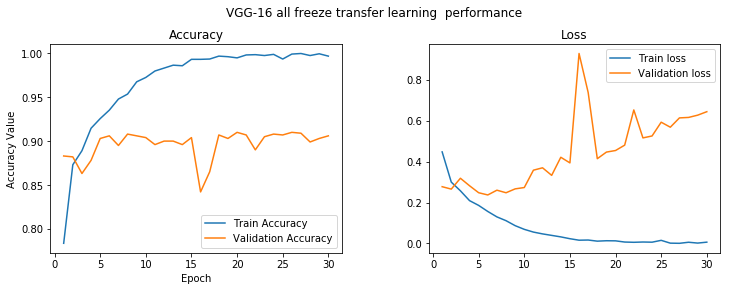

In [17]:
# lets now train the model

history_vgg = model_vgg.fit(x=train_features_vgg, y=train_labels_enc,
                            validation_data=(
                                validation_features_vgg, validation_labels_enc),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 all freeze transfer learning  performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(epoch_list, history_vgg.history['acc'], label='Train Accuracy')
ax1.plot(
    epoch_list, history_vgg.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg.history['loss'], label='Train loss')
ax2.plot(epoch_list, history_vgg.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
model_vgg.save('cats_dogs_vgg16_basicCNN.h5')

We get a model with validation **accuracy** close to **89% - 90%**, we can see the model is **overfitting** after the **fifth epoch** ,overall this seems to be the **best model** so far. Let's now try to use **image augmentation** on this model to **avoid overfitting.**

# 1.1 Pre-trained model as Feature extractor plus image aumentation

In [19]:
train_generator = train_datagen.flow(
    train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(
    validation_imgs, validation_labels_enc, batch_size=20)

We **will not** extract the bottleneck features **as last time** since we will trainig on data generatos. We will instead pass the **vgg_model** as **input** to our own model. We made the learning rate a lit smaller since we will be training for 100 epochs and don not want any sudden abrupt adjusment to our weight.

In [20]:
# lets now build the model.

model_vgg_imgaug = Sequential()

model_vgg_imgaug.add(vgg_model)
model_vgg_imgaug.add(Dense(512, activation='relu', input_dim=input_shape))
model_vgg_imgaug.add(Dropout(0.3))
model_vgg_imgaug.add(Dense(512, activation='relu'))
model_vgg_imgaug.add(Dropout(0.3))
model_vgg_imgaug.add(Dense(1, activation='sigmoid'))

model_vgg_imgaug.compile(loss='binary_crossentropy',
                         optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])
model_vgg_imgaug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

Epoch 1/100
100/100 [==============================] - 953s 10s/step - loss: 0.6591 - acc: 0.6080 - val_loss: 0.5079 - val_acc: 0.7950
Epoch 2/100
100/100 [==============================] - 916s 9s/step - loss: 0.5814 - acc: 0.6940 - val_loss: 0.4325 - val_acc: 0.8110
Epoch 3/100
100/100 [==============================] - 914s 9s/step - loss: 0.5210 - acc: 0.7473 - val_loss: 0.3748 - val_acc: 0.8480
Epoch 4/100
100/100 [==============================] - 916s 9s/step - loss: 0.4862 - acc: 0.7690 - val_loss: 0.3330 - val_acc: 0.8610
Epoch 5/100
100/100 [==============================] - 916s 9s/step - loss: 0.4691 - acc: 0.7743 - val_loss: 0.3150 - val_acc: 0.8680
Epoch 6/100
100/100 [==============================] - 917s 9s/step - loss: 0.4459 - acc: 0.7790 - val_loss: 0.3013 - val_acc: 0.8740
Epoch 7/100
100/100 [==============================] - 921s 9s/step - loss: 0.4442 - acc: 0.7917 - val_loss: 0.2971 - val_acc: 0.8780
Epoch 8/100
100/100 [==============================] - 926s 9

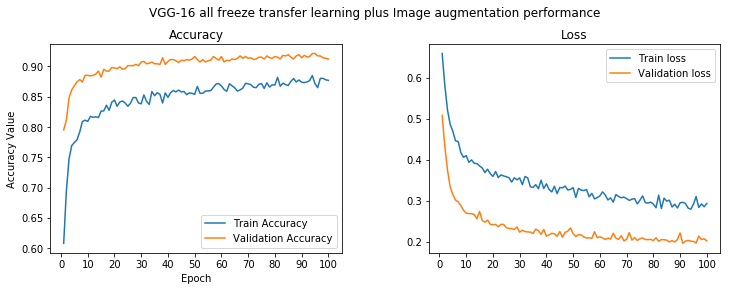

In [21]:
# training the model

history_vgg_imgaug = model_vgg_imgaug.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                                                    validation_data=val_generator, validation_steps=50,
                                                    verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(
    'VGG-16 all freeze transfer learning plus Image augmentation performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 101))
ax1.plot(epoch_list, history_vgg_imgaug.history['acc'], label='Train Accuracy')
ax1.plot(
    epoch_list, history_vgg_imgaug.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg_imgaug.history['loss'], label='Train loss')
ax2.plot(
    epoch_list, history_vgg_imgaug.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
# lets save the model

model_vgg_imgaug.save('cats_dogs_vgg16_imgAug.h5')

# 2. Pre-trained model with fine-tuning in the 4th and 5th convolution blocks plus image augmentation

we will now **unfreeze** the fourth and fifth convolution blocks of the VGG-16 model and adjust their weights.

In [14]:
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Layer name', 'Layer trainable'])

,Layer type,Layer name,Layer trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001EE9261D278>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x000001EE8B9C0A90>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x000001EEC7E42128>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x000001EEC7E97C50>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x000001EE8B9708D0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x000001EEC7EF5B38>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x000001EEC76A45C0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x000001EEC76BF358>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x000001EEC76D4A90>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x000001EEC76E9F28>,block3_conv3,False


We will use the **same model architecture** than the previous model but will **reduce the learning rate slightly** since we do not want to abruptly update the weights of the VGG-16 model.

In [15]:
train_generator = train_datagen.flow(
    train_imgs, train_labels_enc, batch_size=30)

val_generator = val_datagen.flow(
    validation_imgs, validation_labels_enc, batch_size=20)

model_vgg_FT_imgaug = Sequential()
model_vgg_FT_imgaug.add(vgg_model)
model_vgg_FT_imgaug.add(Dense(512, activation='relu', input_dim=input_shape))
model_vgg_FT_imgaug.add(Dropout(0.3))
model_vgg_FT_imgaug.add(Dense(512, activation='relu'))
model_vgg_FT_imgaug.add(Dropout(0.3))
model_vgg_FT_imgaug.add(Dense(1, activation='sigmoid'))

model_vgg_FT_imgaug.compile(loss='binary_crossentropy',
                            optimizer=optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])
model_vgg_FT_imgaug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

Notice that this time we have **more trainable params** than in the last model with all convolution blocks frozen .

Epoch 1/30
100/100 [==============================] - 1673s 17s/step - loss: 0.5896 - acc: 0.6803 - val_loss: 0.3658 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 1563s 16s/step - loss: 0.4002 - acc: 0.8143 - val_loss: 0.3312 - val_acc: 0.8680
Epoch 3/30
100/100 [==============================] - 1456s 15s/step - loss: 0.3422 - acc: 0.8527 - val_loss: 0.2618 - val_acc: 0.8950
Epoch 4/30
100/100 [==============================] - 1445s 14s/step - loss: 0.3172 - acc: 0.8567 - val_loss: 0.2045 - val_acc: 0.9140
Epoch 5/30
100/100 [==============================] - 1452s 15s/step - loss: 0.2822 - acc: 0.8807 - val_loss: 0.1868 - val_acc: 0.9280
Epoch 6/30
100/100 [==============================] - 1448s 14s/step - loss: 0.2597 - acc: 0.8843 - val_loss: 0.1778 - val_acc: 0.9280
Epoch 7/30
100/100 [==============================] - 1524s 15s/step - loss: 0.2662 - acc: 0.8850 - val_loss: 0.1807 - val_acc: 0.9300
Epoch 8/30
100/100 [==============================] - 1

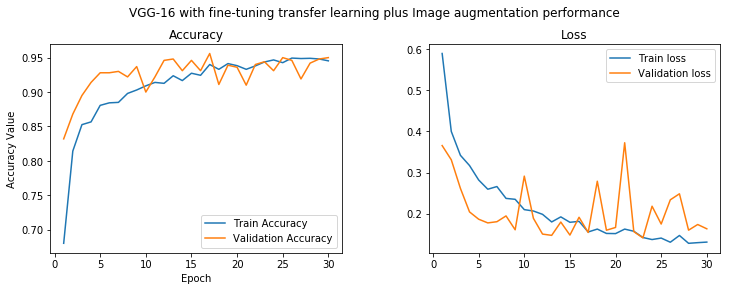

In [16]:
# lets now train the model

history_vgg_FT_imgaug = model_vgg_FT_imgaug.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                                                          validation_data=val_generator, validation_steps=50,
                                                          verbose=1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(
    'VGG-16 with fine-tuning transfer learning plus Image augmentation performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, 31))
ax1.plot(
    epoch_list, history_vgg_FT_imgaug.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list,
         history_vgg_FT_imgaug.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history_vgg_FT_imgaug.history['loss'], label='Train loss')
ax2.plot(
    epoch_list, history_vgg_FT_imgaug.history['val_loss'], label='Validation loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel = ('Loss Value')
ax2.set_xlabel = ('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

model_vgg_FT_imgaug.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

# Evaluating the Deep learnig models on the **Test Data**

In [14]:
# We import some utils and load the saved models

from keras.models import load_model
import model_evaluation_utils as meu

basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_vgg16_basicCNN.h5')
tl_img_aug_cnn = load_model('cats_dogs_vgg16_imgAug.h5')
tl_img_aug_finetune_cnn = load_model(
    'cats_dogs_tlearn_finetune_img_aug_cnn.h5')

In [15]:
# lets now define some fuctions


def num2class_label_transformer(
    l): return ['cat' if x == 0 else 'dog' for x in l]


def class2num_label_transformer(l): return [0 if x == 'cat' else 1 for x in l]


def get_bottleneck_feautures(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

We will test the performance of the models by predicting the test dataset, lets load up and prepare the **Test dataset** so we can later make the predictions and get the metrics of the models.

In [26]:
test_files_path = glob.glob('dog_cat_test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM))
             for img in test_files_path]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip()
               for fn in test_files_path]

test_imgs = test_imgs.astype('float32')
test_imgs /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape', test_imgs.shape)
print(test_labels[497:503], test_labels_enc[497:503])

Test dataset shape (1000, 150, 150, 3)
['cat', 'cat', 'cat', 'dog', 'dog', 'dog'] [0, 0, 0, 1, 1, 1]


## Model 1: Basic CNN model with regularization performance on Test dataset.

In [30]:
predictions = basic_cnn.predict_classes(test_imgs, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(
    true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.782
Precision: 0.7829
Recall: 0.782
F1 Score: 0.7818

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        cat       0.80      0.75      0.78       500
        dog       0.77      0.81      0.79       500

avg / total       0.78      0.78      0.78      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  377        123
        dog  95         405


## Model 2: Basic CNN model with image augmentation performance on Test dataset.

In [31]:
predictions = img_aug_cnn.predict_classes(test_imgs, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(
    true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.865
Precision: 0.8661
Recall: 0.865
F1 Score: 0.8649

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        cat       0.89      0.84      0.86       500
        dog       0.85      0.89      0.87       500

avg / total       0.87      0.86      0.86      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  419        81 
        dog  54         446


## Model 3: TL - Pre-trained CNN as feature extractor performance on Test dataset.

In [32]:
test_bottleneck_features = get_bottleneck_feautures(vgg_model, test_imgs)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(
    true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.907
Precision: 0.907
Recall: 0.907
F1 Score: 0.907

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        cat       0.91      0.91      0.91       500
        dog       0.91      0.91      0.91       500

avg / total       0.91      0.91      0.91      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  453        47 
        dog  46         454


## Model 4: TL - Pre-trained CNN as feature extractor plus image augmentation performance on Test dataset.

In [34]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(
    true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.912
Precision: 0.9122
Recall: 0.912
F1 Score: 0.912

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        cat       0.92      0.90      0.91       500
        dog       0.90      0.92      0.91       500

avg / total       0.91      0.91      0.91      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  451        49 
        dog  39         461


## Model 5: TL - Pre-trained CNN with fine-tuning plus image augmentation performance on Test dataset.

In [35]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(
    true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.959
Precision: 0.9594
Recall: 0.959
F1 Score: 0.959

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        cat       0.97      0.94      0.96       500
        dog       0.95      0.97      0.96       500

avg / total       0.96      0.96      0.96      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   cat  dog
Actual: cat  472        28 
        dog  13         487


# ROC(receiver operating characteristic) curves of the worst and best models.

ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its **discrimination threshold is varied.**  
The ROC curve is **created by** plotting the true positive rate **(TPR)** against the false positive rate **(FPR)** at various threshold settings

## ROC of Worst model (Basic CNN with regularization)

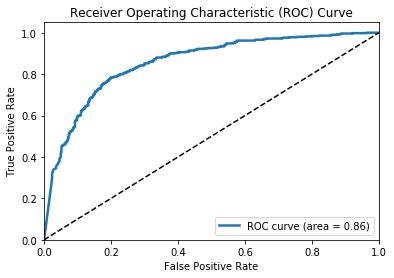

In [111]:
meu.plot_model_roc_curve(basic_cnn, test_imgs,
                         true_labels=test_labels_enc, class_names=[0, 1])

## ROC of Best model (TL - Pre-trained CNN with fine-tuning plus image augmentation)

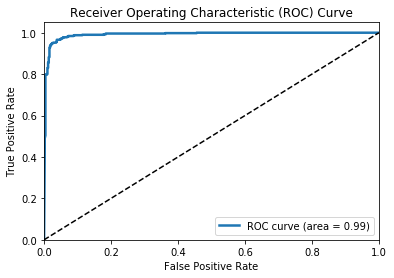

In [112]:
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs,
                         true_labels=test_labels_enc, class_names=[0, 1])

# Misclassified images of the best model
We want to **save** the images that the **best model** is **misclassifying** to see if we can visualy find any patterns that could **hinder the classification task.**

In [107]:
errors_index = [i for i in range(
    len(test_labels)) if test_labels[i] != predictions[i]]

img_misclass = [test_files_path[i] for i in errors_index]

In [110]:
# writing the misclassified images in our disk so we can see them.

imgs_misclass_dir = 'dog_cat_misclassified'

os.mkdir(imgs_misclass_dir) if not os.path.isdir(imgs_misclass_dir) else None

for fn in img_misclass:
    shutil.copy(fn, imgs_misclass_dir)